# Run 2

The goal here is to tweak the model a little bit to yield more localized strain.
Here again are the images from the previous notebook that show the results of other models, some of which are more similar to our results than others.
Think about what we can change in our model to get different results.

## Possible changes to make

Note that any change we make may also affect how long it takes to run the model. 
Our goal is to stay within the 10-minute time frame that the original model used.

Considerations
 - What type of plot is more helpful for visualizing strain localization?
 - Does this visualization actually need the full hour of model simulation time?
 - If we decrease the model simulation time from 1 hour to, say 30 minutes, what may change?

Here is a table of some things you may want to try and how they could effect the run time.

| Parameter | Change | Change in run time |
|-----------|-----------|----------------------|
| Mesh resolution | double it | ~4x longer     |
| Particles per cell | double it | ~2x longer  |
| Sand cohesion | reduce it | no effect? |
| Sand Friction angle | reduce it | no effect? |
| Sand Viscosity      | ??? | ??? |
| Solver tolerance    | increase by 10x | reduced but how much? |


Make your change in the code below, and run the cells to see the results. You can run the code cell-by-cell as you scroll down (Shift+Enter). If a cell fails to run, you probably have a typo.

## Imports and unit scaling
### Don't change this

In [34]:
import UWGeodynamics as GEO
u = GEO.UnitRegistry

velocity = 2.5 * u.centimeter / u.hour
model_length = 20. * u.centimeter
bodyforce = 1560 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

## Setup model resolution and domain size
### Change `elementRes` to increase resolution

In [35]:

# since I increase the number of cells, I don't think so many particles are necessary
# 40 particles per cell would yield 1.6 million particles!
GEO.rcParams['swarm.particles.per.cell.2D'] = 6 # default, 40
GEO.rcParams['popcontrol.particles.per.cell.2D'] = 6 # default, 40

Model = GEO.Model(elementRes=(400, 100), # increased from 120x30 -> increased cells by 11x
                  minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                  maxCoord=(20. * u.centimeter, 1.5 * u.centimeter), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))


Model.mesh_advector(axis=0)

# This sets up a grid that is only used for visualization. Do not change.
Model.add_visugrid(elementRes=(120, 30), 
                   minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                   maxCoord=(20. * u.centimeter, 0.0 * u.centimeter))

## Material layouts
### Do not change

In [36]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=Model.bottom))
sand1 = Model.add_material(name="Sand1", shape=GEO.shapes.Layer(top=0.*u.centimeter, bottom=Model.bottom))
sand2 = Model.add_material(name="Sand2", shape=GEO.shapes.Layer(top=-1. * u.centimeter, bottom=-2. * u.centimeter))

vertices = [( 5.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.5 * u.centimeter),
            ( 5.* u.centimeter, -3.5 * u.centimeter)]

silicon = Model.add_material(name="Silicon", shape=GEO.shapes.Polygon(vertices))

## Passive Tracers
### No impact on model results

In [37]:
import numpy as np

npoints = 1000

coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = GEO.nd(sand1.top)

Model.add_passive_tracers(name="Interface1", vertices=coords)

coords[:, 1] = GEO.nd(sand2.top)
Model.add_passive_tracers(name="Interface2", vertices=coords)

coords[:, 1] = GEO.nd(sand2.bottom)
Model.add_passive_tracers(name="Interface3", vertices=coords)

Failed to open socket, max retries reached



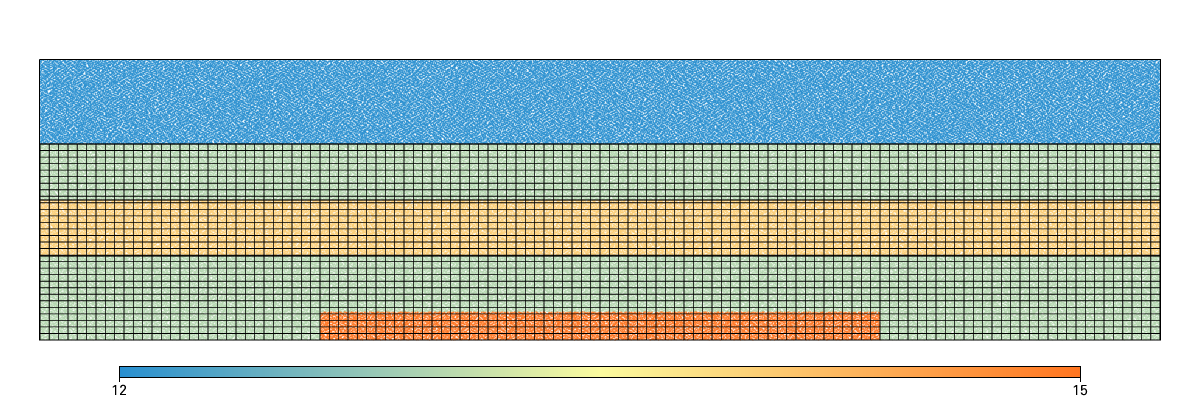

Server start failed:  'NoneType' object has no attribute 'family'


In [38]:
from UWGeodynamics import visualisation as vis
Fig = vis.Figure(figsize=(1200,400))
properties = {"linewidth":0.35}
Fig.Points(Model.Interface1_tracers, pointSize=2.0)
Fig.Points(Model.Interface2_tracers, pointSize=2.0)
Fig.Points(Model.Interface3_tracers, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.Mesh(Model._visugrid.mesh, lineWidth=0.5)
Fig.properties=properties
Fig.show()

## Material densities and viscosities

In [39]:
# Define densities
air.density = 10. * u.kilogram / u.metre**3
sand1.density = 1560. * u.kilogram / u.metre**3
sand2.density = 1560. * u.kilogram / u.metre**3
silicon.density = 965. * u.kilogram / u.metre**3

# Scalar viscosities
air.viscosity     = 1.0e2  * u.pascal * u.second
sand1.viscosity   = 1.0e13 * u.pascal * u.second
sand2.viscosity   = 1.0e13 * u.pascal * u.second
silicon.viscosity = 5.0e4  * u.pascal * u.second

# Plasticity


In [40]:
sandPlasticity = GEO.DruckerPrager(cohesion=10. * u.pascal, # before softening
                                     cohesionAfterSoftening=10. * u.pascal,
                                     frictionCoefficient=0.73, # before softening, radians
                                     frictionAfterSoftening=0.60) # after softening, radians

# note that 30 degress ~ 0.5 rad

# assign plastic behaviour to sand1 and sand2 materials
sand1.plasticity = sandPlasticity
sand2.plasticity = sandPlasticity

## Boundary conditions
### Do not change

In [41]:
import underworld.function as fn

conditions = [(Model.x > GEO.nd(10.1 * u.centimetre), GEO.nd(2.5 * u.centimeter / u.hour)),
              (Model.x > GEO.nd(9.9 * u.centimetre), (Model.x - GEO.nd(9.9 * u.centimetre)) * GEO.nd(velocity) / GEO.nd(0.2 * u.centimetre)),
              (True, 0.0)]

fn_condition = fn.branching.conditional(conditions)

Model.set_velocityBCs(left=[0 * u.centimeter / u.hour, None],
                      right=[2.5 * u.centimeter / u.hour, None],
                      bottom=[fn_condition, 0.0])

## Initialise Model

In [42]:
Model.minViscosity = 1.0e2 * u.pascal * u.second
Model.maxViscosity = 1.0e9 * u.pascal * u.second

Model.init_model(pressure="lithostatic")

Failed to open socket, max retries reached



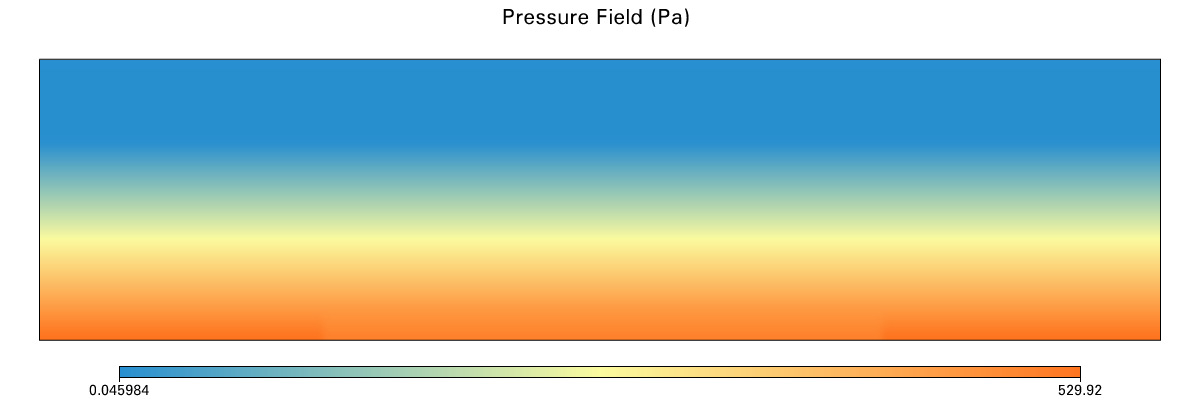

In [43]:
FigPressure = vis.Figure(figsize=(1200, 400), title="Pressure Field (Pa)", quality=3)
FigPressure.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.pascal))
FigPressure.show()

Server start failed:  'NoneType' object has no attribute 'family'
Failed to open socket, max retries reached



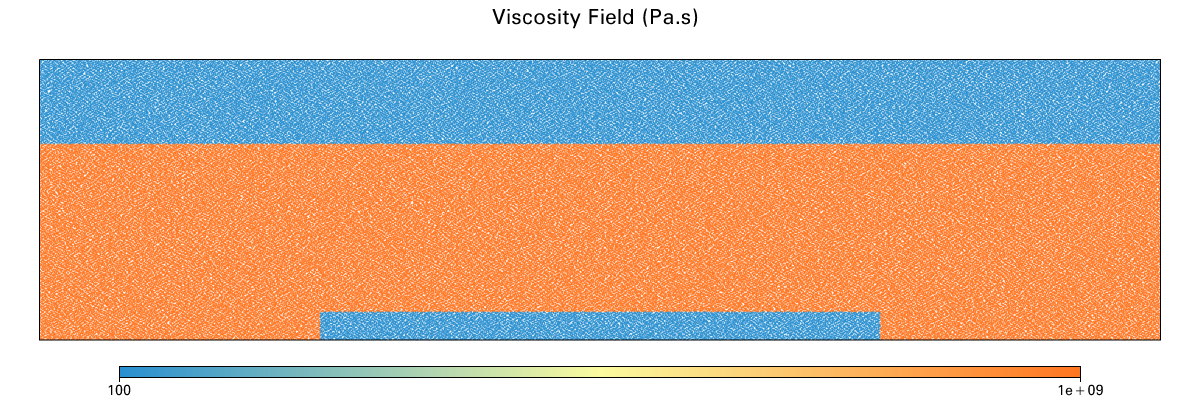

Server start failed:  'NoneType' object has no attribute 'family'


In [44]:
FigViscosity = vis.Figure(figsize=(1200, 400), title="Viscosity Field (Pa.s)", quality=3)
FigViscosity.Points(Model.swarm, GEO.dimensionalise(Model.viscosityField, u.pascal * u.second), pointSize=2.0)
FigViscosity.show()

Failed to open socket, max retries reached



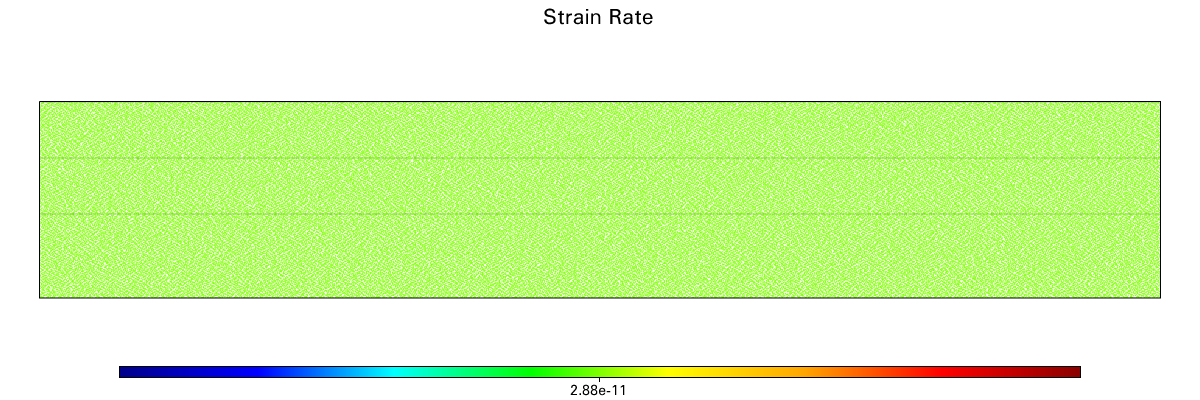

Server start failed:  'NoneType' object has no attribute 'family'


In [45]:
map_dict = {
    air.index: 0.,
    sand1.index: 1.,
    sand2.index: 1.,
    silicon.index: 1.
}
mask = GEO.uw.function.branching.map(fn_key=Model.materialField, mapping=map_dict)

FigStrainRate = vis.Figure(figsize=(1200, 400), title="Strain Rate", quality=3)
FigStrainRate.Points(Model.swarm, fn_colour=Model.strainRateField, fn_mask=mask, pointSize=1.5, logScale=True, colours="darkblue blue cyan green yellow orange red darkred")
FigStrainRate.Points(Model.Interface1_tracers)
FigStrainRate.Points(Model.Interface2_tracers)
FigStrainRate.Points(Model.Interface3_tracers)

FigStrainRate.show()

## Run model

Running with UWGeodynamics version 2.11.0-dev-485ad28(master)
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 0.6 minute dt: 0.6 minute (2021-11-20 21:51:49)
Step:     2 Model Time: 1.2 minute dt: 0.6 minute (2021-11-20 21:52:22)
Step:     3 Model Time: 1.8 minute dt: 0.6 minute (2021-11-20 21:52:58)
Step:     4 Model Time: 2.4 minute dt: 0.6 minute (2021-11-20 21:53:36)
Step:     5 Model Time: 3.0 minute dt: 0.6 minute (2021-11-20 21:54:14)
Step:     6 Model Time: 3.6 minute dt: 0.6 minute (2021-11-20 21:54:58)
Step:     7 Model Time: 4.2 minute dt: 0.6 minute (2021-11-20 21:55:39)
Step:     8 Model Time: 4.8 minute dt: 0.6 minute (2021-1


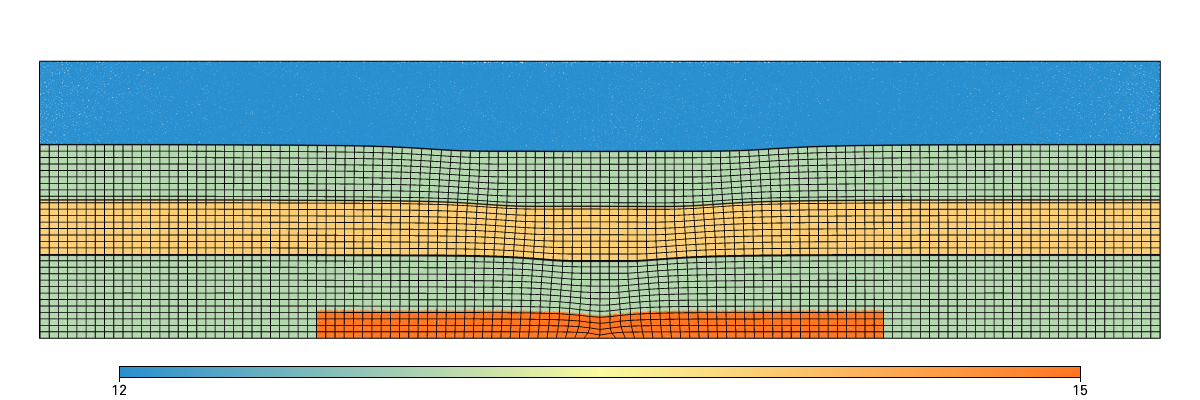

Failed to open socket, max retries reached



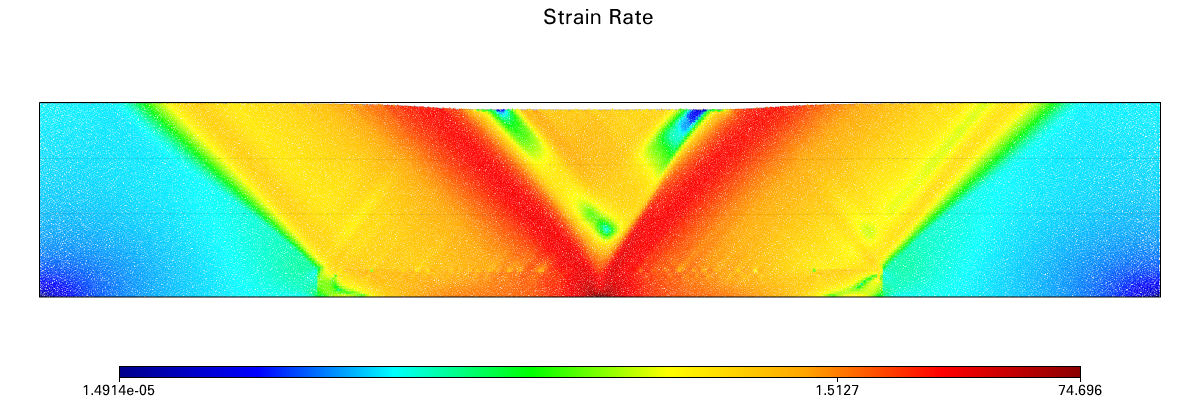

Server start failed:  'NoneType' object has no attribute 'family'
Server start failed:  'NoneType' object has no attribute 'family'


In [46]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

def make_plots():
    Fig.show()
    map_dict = {
    air.index: 0.,
    sand1.index: 1.,
    sand2.index: 1.,
    silicon.index: 1.
    }
    mask = GEO.uw.function.branching.map(fn_key=Model.materialField, mapping=map_dict)

    FigStrainRate = vis.Figure(figsize=(1200, 400), title="Strain Rate", quality=3)
    FigStrainRate.Points(Model.swarm, fn_colour=Model.strainRateField, fn_mask=mask, pointSize=1.5, logScale=True, colours="darkblue blue cyan green yellow orange red darkred")
    FigStrainRate.Points(Model.Interface1_tracers)
    FigStrainRate.Points(Model.Interface2_tracers)
    FigStrainRate.Points(Model.Interface3_tracers)

    FigStrainRate.show()

# I increased the number of cells by 11x, so I wanna decrease the run time by a similar factor
# The idea is that the strain rate field will yield useful information, even after only 6 minutes
Model.run_for(0.1 * u.hours) # Decreased from 1 hour

make_plots()

Running with UWGeodynamics version 2.11.0-dev-485ad28(master)
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type GMG -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 6.6 minute dt: 0.6 minute (2021-11-20 21:59:07)
Step:     2 Model Time: 7.2 minute dt: 0.6 minute (2021-11-20 21:59:46)
Step:     3 Model Time: 7.8 minute dt: 0.6 minute (2021-11-20 22:00:25)
Step:     4 Model Time: 8.4 minute dt: 0.6 minute (2021-11-20 22:01:06)
Step:     5 Model Time: 9.0 minute dt: 0.6 minute (2021-11-20 22:01:46)
Step:     6 Model Time: 9.6 minute dt: 0.6 minute (2021-11-20 22:02:24)
Step:     7 Model Time: 10.2 minute dt: 0.6 minute (2021-11-20 22:03:04)
Step:     8 Model Time: 10.8 minute dt: 0.6 minute (2021-


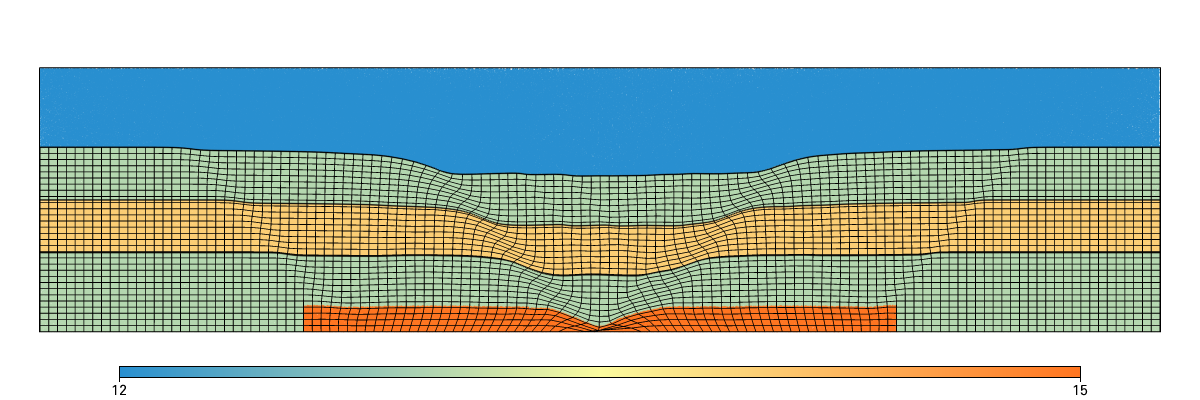

Failed to open socket, max retries reached



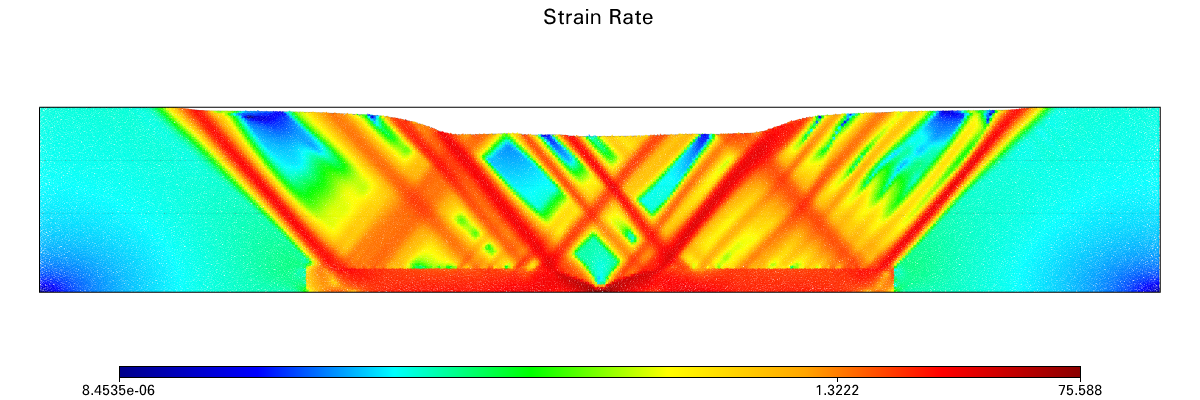

Server start failed:  'NoneType' object has no attribute 'family'
Server start failed:  'NoneType' object has no attribute 'family'


In [47]:
# I was wrong - after only 6 minutes the strain hasn't localized yet
# Run for another 24 minutes - will the strain localize?

Model.run_for(0.4 * u.hours)

make_plots()